**<참고 링크>**
- [Kaggle - PruningDecisionTree](https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial)  
- [StatQuest - CostComplexityPruning](https://www.youtube.com/watch?v=D0efHEJsfHo&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=42)

# How to Pruning decision trees

- 의사결정 트리는 매우 강력하나 오버피팅이 심하다
- 오버피팅을 억제하기 위해 사전 가지치기와 사후 가지치기 방법을 쓸 수 있다.

``사전 가지치기(pre-pruning)`` :  트리를 만드는 와중에 가지치기를 하는 것
    
    - 장점 : 학습 속도 빠름(더 작은 트리를 만들기 때문에)
           : 다양한 파라미터를 자유롭게 조정 가능 
           
    - 단점 : 근시안적임(트리의 끝으로 갈수록 일반화 오차가 더 줄어들지 모르는데, 미리 차단해버리기 때문)
    

``사후 가지치기(post-pruning)`` : 과대적합 된 트리를 하나 만들고 뒤로 가지치기를 하는 것
    
    - 장점 : 더 많은 경우를 보고 어떤 서브 트리를 쓸 지 결정할 수 있다. (과대적합된 Big tree에서부터 subtee까지 일반화 오차를 모두 검증하기 때문에)
           : 적은 하이퍼파라미터 수(alpha만 조정하면 된다.)
    - 단점 : 단순히 leaf Node의 수만 고려함 (sub tree를 분할할 때 tree의 leaf node의 수가 tree score에 포함되어 penalty를 주기 때문에 min_sample같은 트리 분할에 고려되는 다른 파라미터를 고려하지 않는다.

# Import Modules

In [1]:
import numpy as np
import pandas as pd
import os 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Data

In [2]:
data = './heart.csv'
df = pd.read_csv(data)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
X = df.drop(columns=['target'])
y = df['target']
print(X.shape)
print(y.shape)

(303, 13)
(303,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
print(X_train.shape)
print(X_test.shape)

(227, 13)
(76, 13)


# Model Training

- 먼저, 아무 제한이 없는 DT를 만들어 학습

In [5]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

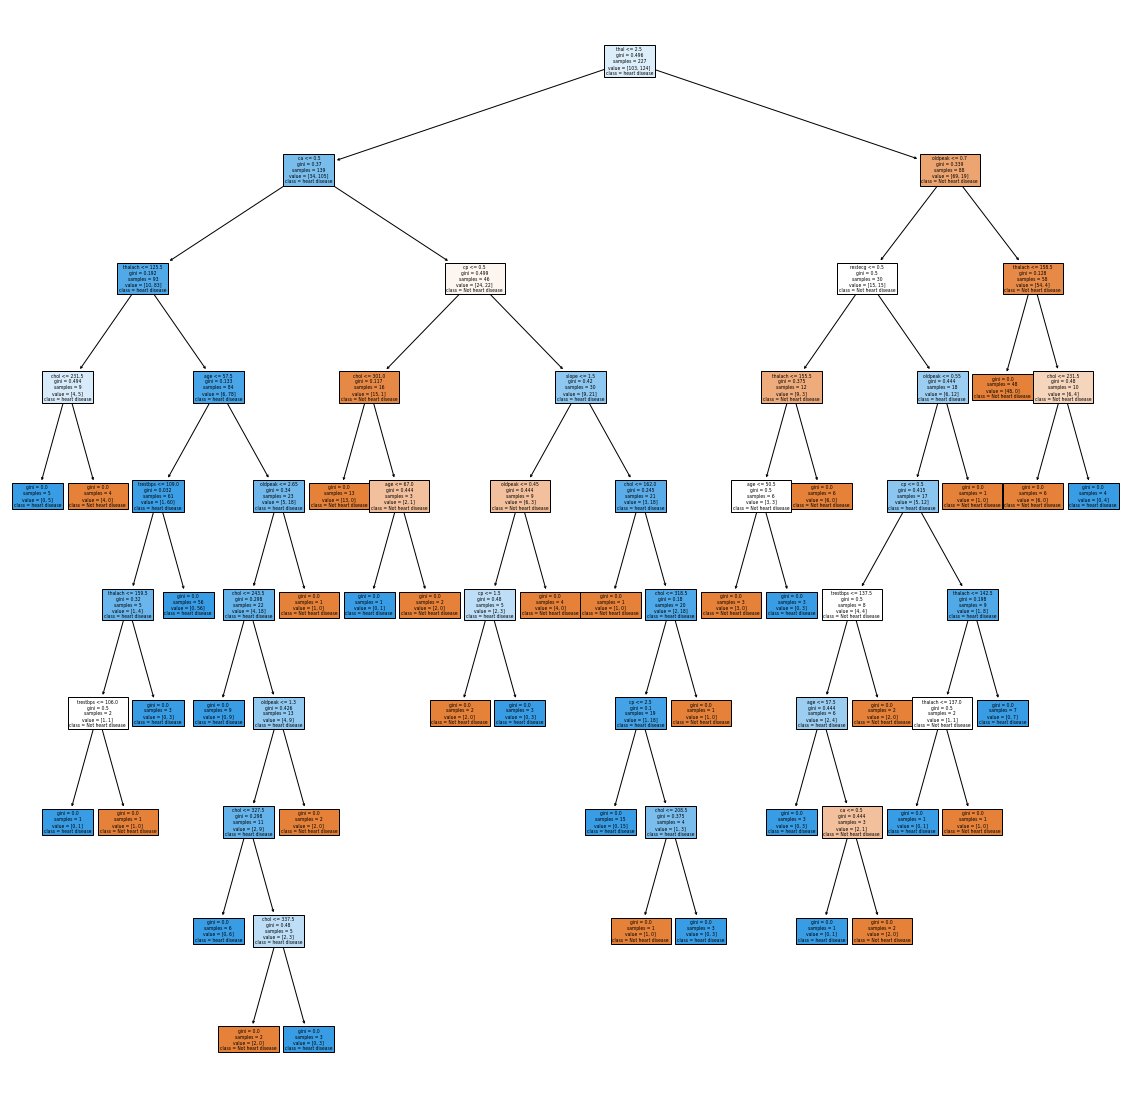

In [6]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease', 'heart disease']
tree.plot_tree(clf, feature_names=features, class_names=classes, filled=True)
plt.show()

In [7]:
def plot_confusionmatrix(y_train_pred, y_train, dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred, y_train)
    sns.heatmap(cf, annot=True, yticklabels=classes, 
               xticklabels=classes, cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

- 학습 정확도가 매우 높은 반면, 테스트 정확도는 매우 낮음

Train score 1.0
Test score 0.6973684210526315
Train Confusion matrix


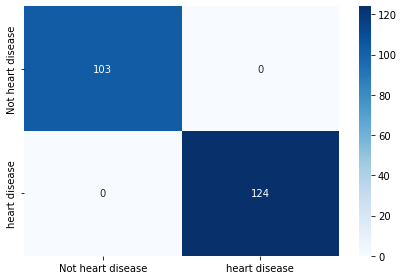

Test Confusion matrix


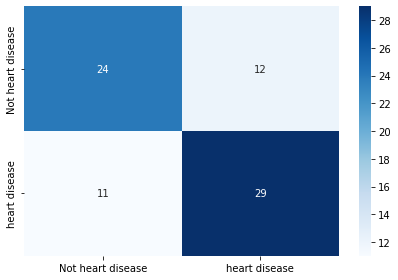

In [8]:
print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_test_pred, y_test)}')
plot_confusionmatrix(y_train_pred, y_train, dom='Train')
plot_confusionmatrix(y_test_pred, y_test, dom='Test')

- 사전 가지치기 매개변수 조정 

``('max_depth', 'min_samples_split', 'min_samples_leaf')``

- 그리고, GridSearchCV로 일반화 오차 검증

In [9]:
params = {
    'max_depth' : [2,4,6,8,10,12],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2]
}

clf = tree.DecisionTreeClassifier(random_state=0)
gcv = GridSearchCV(estimator=clf, param_grid=params)
gcv.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

- 규제가 없는 것보단 낫지만, 여전히 학습 정확도가 매우 높은 반면, 테스트 정확도는 매우 낮음

Train score 0.9074889867841409
Test score 0.6973684210526315
Train Confusion matrix


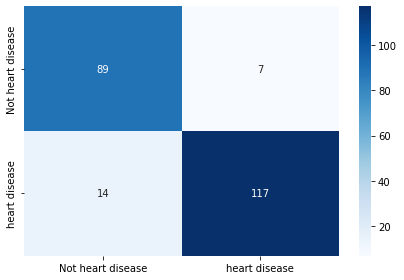

Test Confusion matrix


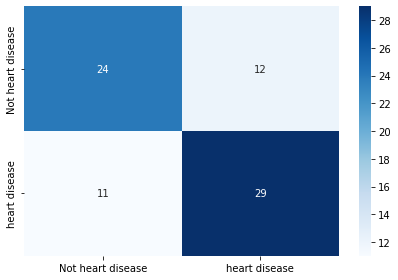

In [10]:
model = gcv.best_estimator_
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_test_pred, y_test)}')
plot_confusionmatrix(y_train_pred, y_train, dom='Train')
plot_confusionmatrix(y_test_pred, y_test, dom='Test')

- 사전 가지치기를 한 후 트리의 깊이와 트리의 노드 수가 많이 줄어든 것을 볼 수 있다.

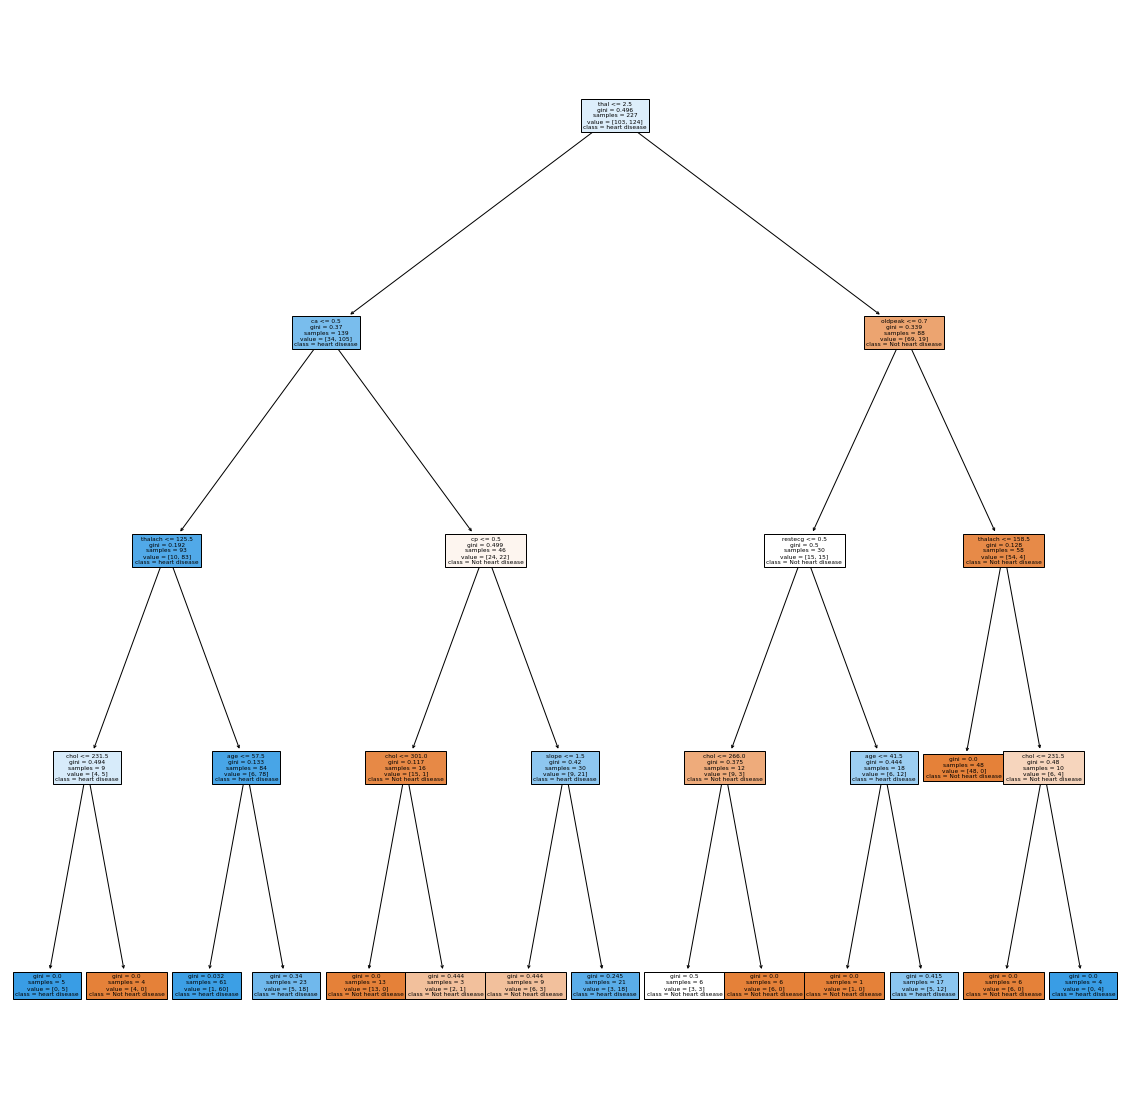

In [11]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease', 'heart disease']
tree.plot_tree(model, feature_names=features, class_names=classes, filled=True)
plt.show()

- 사후 가지치기 매개 변수 조정 

``(ccp_alphas)``

In [12]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00288871 0.00391581 0.00412996 0.00417343 0.00548213
 0.00673689 0.00715445 0.00881057 0.00991189 0.01101322 0.01477226
 0.0152297  0.01640589 0.03236643 0.03736353 0.04652389 0.13817742]


In [20]:
impurities # alpha에 따른 RSS

array([0.        , 0.00866614, 0.01649776, 0.02475767, 0.03310453,
       0.0605152 , 0.10093654, 0.11524544, 0.13286658, 0.15269037,
       0.16370359, 0.1932481 , 0.20847781, 0.2412896 , 0.27365602,
       0.31101955, 0.35754344, 0.49572086])

In [13]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf= tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

- ccp_alphas가 클수록 트리의 깊이와, 노드 수가 줄어들고 있다. 

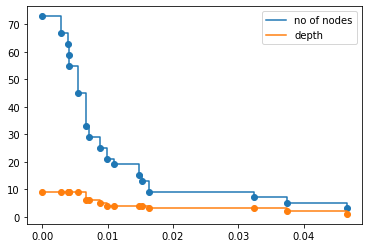

In [14]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)
plt.plot(ccp_alphas, node_counts, label='no of nodes',
        drawstyle='steps-post')
plt.plot(ccp_alphas, depth, label='depth', 
        drawstyle='steps-post')
plt.legend()
plt.show()

- ccp_alphas가 클수록 train_accuracy는 낮아지고, test_accuracy는 높아지고 있다.

- 이 사이에 0.02 주변이 train_accuracy와 test_accuracy의 차이가 적고, 점수도 높은 구간이다. 

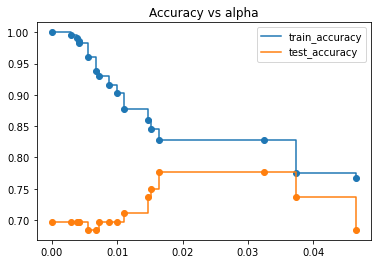

In [15]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred, y_train))
    test_acc.append(accuracy_score(y_test_pred, y_test))
    
plt.scatter(ccp_alphas, train_acc)                    
plt.scatter(ccp_alphas, test_acc)
plt.plot(ccp_alphas, train_acc, label='train_accuracy',
        drawstyle='steps-post')
plt.plot(ccp_alphas, test_acc, label='test_accuracy',
        drawstyle='steps-post')
plt.legend()      
plt.title('Accuracy vs alpha')
plt.show()

Train score 0.8281938325991189
Test score 0.7763157894736842
Train Confusion matrix


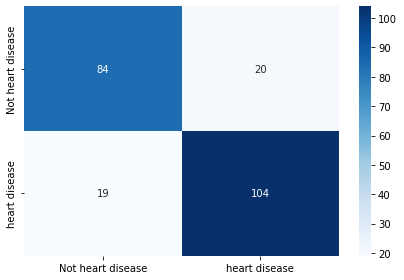

Test Confusion matrix


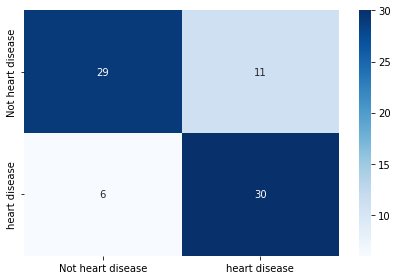

In [16]:
clf_ = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.020)
clf_.fit(X_train, y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred, y_train)}')
print(f'Test score {accuracy_score(y_test_pred, y_test)}')
plot_confusionmatrix(y_train_pred, y_train, dom='Train')
plot_confusionmatrix(y_test_pred, y_test, dom='Test')

# Cross Validation 추가

In [22]:
clfs_cost_

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [47]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00288871 0.00391581 0.00412996 0.00417343 0.00548213
 0.00673689 0.00715445 0.00881057 0.00991189 0.01101322 0.01477226
 0.0152297  0.01640589 0.03236643 0.03736353 0.04652389 0.13817742]


In [51]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
params = {
    'ccp_alpha' : ccp_alphas
}
clf = tree.DecisionTreeClassifier(random_state=0)
gcv = GridSearchCV(clf, params)
gcv.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'ccp_alpha': array([0.        , 0.00288871, 0.00391581, 0.00412996, 0.00417343,
       0.00548213, 0.00673689, 0.00715445, 0.00881057, 0.00991189,
       0.01101322, 0.01477226, 0.0152297 , 0.01640589, 0.03236643,
       0.03736353, 0.04652389, 0.13817742])})

In [52]:
gcv.best_params_

{'ccp_alpha': 0.011013215859030832}

In [58]:
gcv.best_score_

0.7710144927536232

In [69]:
clf_ = gcv.best_estimator_
y_test_pred= clf_.predict(X_test)
print(accuracy_score(y_test_pred, y_test))

0.7105263157894737
